In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

font sizes set


## Define a model

In [2]:
from keras.layers import Conv1D, Dense, Flatten, AveragePooling1D
from keras.models import Sequential

# Use different conv layers
def build_model(input_shape, n_categories,
                
                # Convolution parameters
                conv_filter_sizes = [16, 8],
                conv_kernel_sizes = [5, 3],
                conv_pool_sizes = [2, None],
                conv_padding="valid",
                
                # Dense parameters
                n_dense_layers=2,
                dense_nodes=256,
                **kwargs):
    
    n_conv_blocks = len(conv_filter_sizes)

    model = Sequential()
    
    # Conv1d + temporal average pooling
    for block_id in range(n_conv_blocks):
        conv = Conv1D(conv_filter_sizes[block_id], conv_kernel_sizes[block_id], 
                      input_shape=input_shape,
                      activation="relu", 
                      name=f"conv_{block_id}",
                        padding=conv_padding
                     )
        
        
        model.add(conv)
        if block_id < n_conv_blocks - 1:
            pool = AveragePooling1D(pool_size=conv_pool_sizes[block_id], name=f"avg_pooling_{block_id}")
            model.add(pool)
            
    # Flattens stuff :3
    model.add(Flatten())
    
    # A good dose of Dense layers never hurted anybody
    for block_id in range(n_dense_layers):
        model.add(Dense(dense_nodes, 
                        activation="relu", 
                        name=f"dense_{block_id}"))
    
    # Let the garbage out
    model.add(Dense(n_categories, 
                    activation="softmax",
                    name="output"))
    
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

2023-07-09 16:38:24.951545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 16:38:25.338147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 16:38:25.339894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 16:38:27.285416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tuning (for prediction of almost all categories)

### Prepare the different resolutions

In [3]:
# In the tuning the spectral resolution is optimized too
from djanloo_fourier import FixedResolutionSTFTransformer
from tensorflow.keras.preprocessing.sequence import pad_sequences

STFT_dict = dict()
possible_resolutions = [90, 100, 110, 115]
for res in possible_resolutions:
    ## Really gets the dataset of STFTs
    fixedtr = FixedResolutionSTFTransformer(n_spectral_points=res,
                                            pad_spectra=False,
                                            verbose=True)
    
    # Gets STFTs
    STFTs = fixedtr.transform(traces["clean_trace"])
    STFT_dict[res] = pad_sequences(STFTs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:10<00:00, 232.07it/s]


In [4]:
from sklearn.preprocessing import LabelEncoder

# Gets labels
enc = LabelEncoder()
labels = np.array([f"{s} {e} {vc}" for s,e,vc in zip(df.sex, df.emotion, df.vocal_channel)])
y = enc.fit_transform(labels)

### Define the objective function to maximise

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def objective(trial, train_idxs, val_idxs):
    global y, possible_resolutions
    
    epochs=trial.suggest_int('epochs',15,40)
    
    # Gets the data
    X = STFT_dict[trial.suggest_categorical("resolution", choices=possible_resolutions)]
    
    # Builds the convolutional parameters
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 3)
    filter_sizes, kernel_sizes, pool_sizes = [], [], []  
    for block_id in range(n_conv_blocks):
        filter_sizes.append(trial.suggest_int(f'filters_{block_id}', 2, 16))
        kernel_sizes.append(trial.suggest_int(f'kernels_{block_id}', 3, 9))
        pool_sizes.append(trial.suggest_int(f'pool_{block_id}', 2, 8))

    
    ## Concerning the model ...
    pars = dict(## Conv stuff 
                conv_filter_sizes=filter_sizes, 
                conv_kernel_sizes=kernel_sizes, 
                conv_pool_sizes=pool_sizes,
                conv_padding=trial.suggest_categorical("conv_padding", choices=["valid", "causal"]),
        
                ## Dense stuff
                n_dense_layers=trial.suggest_int('n_dense_layers', 1, 3), 
                dense_nodes=trial.suggest_int('dense_nodes', 16, 512)
               )
    print(f"running model having {pars} with SpRes = {fixedtr.n_spectral_points} for epochs = {epochs}")
    
    model = build_model(X.shape[1:], len(np.unique(y)), **pars)
    model.fit(
                    X[train_idxs], y[train_idxs], 
                    epochs=epochs,
                    batch_size=trial.suggest_int('batch_size', 16, 32),
                    verbose=False
                    )
    
    ## Estimate accuracy
    y_pred = np.argmax(model.predict(X[val_idxs], verbose=False), axis=1)
    acc = accuracy_score(y[val_idxs], y_pred)
    
    return acc

In [6]:
## Splits the dataset
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

In [7]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=300, n_jobs=1, catch=ValueError)

[I 2023-07-09 16:39:07,335] A new study created in memory with name: no-name-2ced07f9-4030-40ca-b2dd-f793ed3a41b3


running model having {'conv_filter_sizes': [5, 13], 'conv_kernel_sizes': [7, 8], 'conv_pool_sizes': [5, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 350} with SpRes = 115 for epochs = 25


2023-07-09 16:39:08.268265: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 207979200 exceeds 10% of free system memory.
2023-07-09 16:39:11.828570: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19976320 exceeds 10% of free system memory.
2023-07-09 16:39:11.828977: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19976320 exceeds 10% of free system memory.
2023-07-09 16:39:11.829670: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30769200 exceeds 10% of free system memory.
2023-07-09 16:39:11.864280: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19976320 exceeds 10% of free system memory.
[I 2023-07-09 16:39:54,219] Trial 0 finished with value: 0.363265306122449 and parameters: {'epochs': 25, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 5, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 8, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 350, 'b

running model having {'conv_filter_sizes': [3, 16, 10], 'conv_kernel_sizes': [7, 5, 5], 'conv_pool_sizes': [7, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 157} with SpRes = 115 for epochs = 40


[I 2023-07-09 16:40:51,039] Trial 1 finished with value: 0.39591836734693875 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 3, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'filters_2': 10, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 157, 'batch_size': 16}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [15, 3, 15], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [2, 2, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 41} with SpRes = 115 for epochs = 25


[I 2023-07-09 16:41:33,263] Trial 2 finished with value: 0.23265306122448978 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 2, 'filters_1': 3, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 41, 'batch_size': 31}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [14, 11, 6], 'conv_kernel_sizes': [5, 5, 6], 'conv_pool_sizes': [6, 6, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 367} with SpRes = 115 for epochs = 28


[I 2023-07-09 16:42:10,320] Trial 3 finished with value: 0.3551020408163265 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 6, 'filters_2': 6, 'kernels_2': 6, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 367, 'batch_size': 20}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [10, 16], 'conv_kernel_sizes': [9, 3], 'conv_pool_sizes': [5, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 313} with SpRes = 115 for epochs = 28


[I 2023-07-09 16:43:14,642] Trial 4 finished with value: 0.31020408163265306 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 313, 'batch_size': 18}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [9, 7, 3], 'conv_kernel_sizes': [8, 9, 6], 'conv_pool_sizes': [6, 8, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 67} with SpRes = 115 for epochs = 35


[I 2023-07-09 16:44:21,915] Trial 5 finished with value: 0.3510204081632653 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 7, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 3, 'kernels_2': 6, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 67, 'batch_size': 18}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [5, 7, 10], 'conv_kernel_sizes': [8, 9, 8], 'conv_pool_sizes': [4, 2, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 26} with SpRes = 115 for epochs = 35


[I 2023-07-09 16:45:16,580] Trial 6 finished with value: 0.2693877551020408 and parameters: {'epochs': 35, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 5, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 7, 'kernels_1': 9, 'pool_1': 2, 'filters_2': 10, 'kernels_2': 8, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 26, 'batch_size': 23}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [5, 2, 15], 'conv_kernel_sizes': [3, 6, 7], 'conv_pool_sizes': [2, 4, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 122} with SpRes = 115 for epochs = 21


[I 2023-07-09 16:45:42,121] Trial 7 finished with value: 0.363265306122449 and parameters: {'epochs': 21, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 5, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 2, 'kernels_1': 6, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 7, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 122, 'batch_size': 20}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [15, 14, 4], 'conv_kernel_sizes': [8, 8, 4], 'conv_pool_sizes': [7, 7, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 112} with SpRes = 115 for epochs = 18


[I 2023-07-09 16:46:17,861] Trial 8 finished with value: 0.3224489795918367 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 4, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 112, 'batch_size': 16}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [13, 3, 13], 'conv_kernel_sizes': [6, 9, 5], 'conv_pool_sizes': [3, 6, 4], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 405} with SpRes = 115 for epochs = 21


[I 2023-07-09 16:46:50,250] Trial 9 finished with value: 0.3346938775510204 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 3, 'kernels_1': 9, 'pool_1': 6, 'filters_2': 13, 'kernels_2': 5, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 405, 'batch_size': 27}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [2], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 505} with SpRes = 115 for epochs = 40


[I 2023-07-09 16:47:42,961] Trial 10 finished with value: 0.1306122448979592 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 2, 'kernels_0': 4, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 505, 'batch_size': 26}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [2, 13], 'conv_kernel_sizes': [6, 7], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 226} with SpRes = 115 for epochs = 34


[I 2023-07-09 16:48:24,888] Trial 11 finished with value: 0.3224489795918367 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 2, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 7, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 226, 'batch_size': 32}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [5], 'conv_kernel_sizes': [7], 'conv_pool_sizes': [5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 212} with SpRes = 115 for epochs = 40


[I 2023-07-09 16:49:27,249] Trial 12 finished with value: 0.22857142857142856 and parameters: {'epochs': 40, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 5, 'kernels_0': 7, 'pool_0': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 212, 'batch_size': 23}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [7, 16], 'conv_kernel_sizes': [7, 6], 'conv_pool_sizes': [6, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 167} with SpRes = 115 for epochs = 15


[I 2023-07-09 16:49:49,353] Trial 13 finished with value: 0.14285714285714285 and parameters: {'epochs': 15, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 6, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 167, 'batch_size': 29}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [3, 12], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297} with SpRes = 115 for epochs = 31


[I 2023-07-09 16:50:32,430] Trial 14 finished with value: 0.3183673469387755 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 3, 'kernels_0': 5, 'pool_0': 4, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297, 'batch_size': 21}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [7], 'conv_kernel_sizes': [9], 'conv_pool_sizes': [7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 438} with SpRes = 115 for epochs = 24


[I 2023-07-09 16:51:44,428] Trial 15 finished with value: 0.1510204081632653 and parameters: {'epochs': 24, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 7, 'kernels_0': 9, 'pool_0': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 438, 'batch_size': 16}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [4, 10], 'conv_kernel_sizes': [5, 5], 'conv_pool_sizes': [4, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 265} with SpRes = 115 for epochs = 31


[I 2023-07-09 16:52:25,928] Trial 16 finished with value: 0.2897959183673469 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 5, 'pool_0': 4, 'filters_1': 10, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 265, 'batch_size': 25}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [7, 14], 'conv_kernel_sizes': [7, 7], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 347} with SpRes = 115 for epochs = 25


[I 2023-07-09 16:53:09,858] Trial 17 finished with value: 0.3469387755102041 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 347, 'batch_size': 28}. Best is trial 1 with value: 0.39591836734693875.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 212} with SpRes = 115 for epochs = 37


[I 2023-07-09 16:54:08,294] Trial 18 finished with value: 0.46530612244897956 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 212, 'batch_size': 23}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 172} with SpRes = 115 for epochs = 38


[I 2023-07-09 16:55:08,756] Trial 19 finished with value: 0.2 and parameters: {'epochs': 38, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 172, 'batch_size': 18}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 8], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 125} with SpRes = 115 for epochs = 37


[I 2023-07-09 16:56:03,605] Trial 20 finished with value: 0.4 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 125, 'batch_size': 21}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 8], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 102} with SpRes = 115 for epochs = 37


[I 2023-07-09 16:56:59,564] Trial 21 finished with value: 0.37551020408163266 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 102, 'batch_size': 21}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [9, 16], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 195} with SpRes = 115 for epochs = 37


[I 2023-07-09 16:57:53,571] Trial 22 finished with value: 0.31020408163265306 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 195, 'batch_size': 25}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 5], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 141} with SpRes = 115 for epochs = 32


[I 2023-07-09 16:58:38,429] Trial 23 finished with value: 0.42448979591836733 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 141, 'batch_size': 22}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 5], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 234} with SpRes = 115 for epochs = 32


[I 2023-07-09 16:59:19,568] Trial 24 finished with value: 0.4 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 234, 'batch_size': 22}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 83} with SpRes = 115 for epochs = 33


[I 2023-07-09 17:00:10,942] Trial 25 finished with value: 0.27346938775510204 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 83, 'batch_size': 24}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [16, 6], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 136} with SpRes = 115 for epochs = 30


[I 2023-07-09 17:00:43,484] Trial 26 finished with value: 0.4122448979591837 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 6, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 136, 'batch_size': 19}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [16, 5], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 267} with SpRes = 115 for epochs = 30


[I 2023-07-09 17:01:14,498] Trial 27 finished with value: 0.33877551020408164 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 267, 'batch_size': 19}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [14], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 161} with SpRes = 115 for epochs = 30


[I 2023-07-09 17:01:58,537] Trial 28 finished with value: 0.24897959183673468 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 161, 'batch_size': 22}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [16, 6], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 134} with SpRes = 115 for epochs = 34


[I 2023-07-09 17:02:35,058] Trial 29 finished with value: 0.33877551020408164 and parameters: {'epochs': 34, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 6, 'kernels_1': 6, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 134, 'batch_size': 24}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 4], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [4, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 66} with SpRes = 115 for epochs = 27


[I 2023-07-09 17:03:04,210] Trial 30 finished with value: 0.39183673469387753 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 4, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 66, 'batch_size': 19}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [10, 9], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 203} with SpRes = 115 for epochs = 37


[I 2023-07-09 17:03:52,300] Trial 31 finished with value: 0.2816326530612245 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 203, 'batch_size': 22}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 8], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 141} with SpRes = 115 for epochs = 36


[I 2023-07-09 17:04:46,418] Trial 32 finished with value: 0.43673469387755104 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 141, 'batch_size': 21}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 6], 'conv_kernel_sizes': [5, 6], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 148} with SpRes = 115 for epochs = 35


[I 2023-07-09 17:05:32,476] Trial 33 finished with value: 0.30612244897959184 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 6, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 148, 'batch_size': 20}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [14, 9], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 183} with SpRes = 115 for epochs = 33


[I 2023-07-09 17:06:31,204] Trial 34 finished with value: 0.37551020408163266 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 183, 'batch_size': 17}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [15, 5], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 245} with SpRes = 115 for epochs = 29


[I 2023-07-09 17:07:10,929] Trial 35 finished with value: 0.3306122448979592 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 245, 'batch_size': 19}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 7], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 87} with SpRes = 115 for epochs = 38


[I 2023-07-09 17:08:03,595] Trial 36 finished with value: 0.3673469387755102 and parameters: {'epochs': 38, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 7, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 87, 'batch_size': 24}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [10, 10], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 41} with SpRes = 115 for epochs = 27


[I 2023-07-09 17:08:33,002] Trial 37 finished with value: 0.30612244897959184 and parameters: {'epochs': 27, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 10, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 41, 'batch_size': 20}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [14, 8, 7], 'conv_kernel_sizes': [7, 4, 9], 'conv_pool_sizes': [6, 7, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 146} with SpRes = 115 for epochs = 35


[I 2023-07-09 17:09:29,382] Trial 38 finished with value: 0.363265306122449 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 7, 'filters_2': 7, 'kernels_2': 9, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 146, 'batch_size': 23}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [8, 4], 'conv_kernel_sizes': [8, 5], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 56} with SpRes = 115 for epochs = 39


[I 2023-07-09 17:10:34,316] Trial 39 finished with value: 0.02857142857142857 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 4, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 56, 'batch_size': 22}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [15, 6, 2], 'conv_kernel_sizes': [6, 6, 3], 'conv_pool_sizes': [3, 6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 296} with SpRes = 115 for epochs = 32


[I 2023-07-09 17:11:25,058] Trial 40 finished with value: 0.37142857142857144 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 6, 'kernels_1': 6, 'pool_1': 6, 'filters_2': 2, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 296, 'batch_size': 17}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 8], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 124} with SpRes = 115 for epochs = 36


[I 2023-07-09 17:12:19,802] Trial 41 finished with value: 0.3224489795918367 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 124, 'batch_size': 21}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [9, 10], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 108} with SpRes = 115 for epochs = 36


[I 2023-07-09 17:13:11,904] Trial 42 finished with value: 0.32653061224489793 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 108, 'batch_size': 21}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 9], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 136} with SpRes = 115 for epochs = 33


[I 2023-07-09 17:14:08,743] Trial 43 finished with value: 0.30612244897959184 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 136, 'batch_size': 23}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 7], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [3, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 181} with SpRes = 115 for epochs = 39


[I 2023-07-09 17:15:10,844] Trial 44 finished with value: 0.34285714285714286 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 7, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 181, 'batch_size': 20}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 11], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [7, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 211} with SpRes = 115 for epochs = 36


[I 2023-07-09 17:16:11,535] Trial 45 finished with value: 0.2897959183673469 and parameters: {'epochs': 36, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 211, 'batch_size': 19}. Best is trial 18 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [10, 8], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 89} with SpRes = 115 for epochs = 34


[I 2023-07-09 17:16:54,402] Trial 46 finished with value: 0.4775510204081633 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 89, 'batch_size': 25}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [8, 4], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 32} with SpRes = 115 for epochs = 34


[I 2023-07-09 17:17:33,106] Trial 47 finished with value: 0.3224489795918367 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 4, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 32, 'batch_size': 26}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [10, 6, 11], 'conv_kernel_sizes': [5, 5, 9], 'conv_pool_sizes': [5, 7, 7], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 90} with SpRes = 115 for epochs = 29


[I 2023-07-09 17:18:10,394] Trial 48 finished with value: 0.27755102040816326 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 6, 'kernels_1': 5, 'pool_1': 7, 'filters_2': 11, 'kernels_2': 9, 'pool_2': 7, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 90, 'batch_size': 25}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [8, 7], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 157} with SpRes = 115 for epochs = 32


[I 2023-07-09 17:18:43,184] Trial 49 finished with value: 0.4204081632653061 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 7, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 157, 'batch_size': 30}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [6], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 250} with SpRes = 115 for epochs = 32


[I 2023-07-09 17:19:30,946] Trial 50 finished with value: 0.2897959183673469 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 6, 'kernels_0': 5, 'pool_0': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 250, 'batch_size': 30}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [8, 7], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 156} with SpRes = 115 for epochs = 31


[I 2023-07-09 17:20:03,791] Trial 51 finished with value: 0.35918367346938773 and parameters: {'epochs': 31, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 7, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 156, 'batch_size': 29}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [10, 7], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 110} with SpRes = 115 for epochs = 34


[I 2023-07-09 17:20:35,613] Trial 52 finished with value: 0.3795918367346939 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 7, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 110, 'batch_size': 31}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [9, 5], 'conv_kernel_sizes': [4, 7], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 183} with SpRes = 115 for epochs = 29


[I 2023-07-09 17:21:09,726] Trial 53 finished with value: 0.3510204081632653 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 5, 'kernels_1': 7, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 183, 'batch_size': 27}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [12, 2], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 72} with SpRes = 115 for epochs = 35


[I 2023-07-09 17:21:45,917] Trial 54 finished with value: 0.12244897959183673 and parameters: {'epochs': 35, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 2, 'kernels_1': 5, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 72, 'batch_size': 26}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [6, 3], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 222} with SpRes = 115 for epochs = 26


[I 2023-07-09 17:22:16,580] Trial 55 finished with value: 0.2530612244897959 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 6, 'kernels_0': 4, 'pool_0': 4, 'filters_1': 3, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 222, 'batch_size': 23}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [13, 9], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 196} with SpRes = 115 for epochs = 30


[I 2023-07-09 17:22:52,941] Trial 56 finished with value: 0.4326530612244898 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 9, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 196, 'batch_size': 32}. Best is trial 46 with value: 0.4775510204081633.


running model having {'conv_filter_sizes': [13, 11], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197} with SpRes = 115 for epochs = 23


[I 2023-07-09 17:23:21,460] Trial 57 finished with value: 0.5061224489795918 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197, 'batch_size': 32}. Best is trial 57 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 282} with SpRes = 115 for epochs = 22


[I 2023-07-09 17:23:48,547] Trial 58 finished with value: 0.39591836734693875 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 282, 'batch_size': 32}. Best is trial 57 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 195} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:24:15,920] Trial 59 finished with value: 0.49387755102040815 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 195, 'batch_size': 31}. Best is trial 57 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [13, 12], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:24:39,990] Trial 60 finished with value: 0.4122448979591837 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197, 'batch_size': 31}. Best is trial 57 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:25:06,850] Trial 61 finished with value: 0.5265306122448979 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 246} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:25:33,347] Trial 62 finished with value: 0.42448979591836733 and parameters: {'epochs': 20, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 246, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [11, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 330} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:25:59,953] Trial 63 finished with value: 0.4326530612244898 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 330, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 222} with SpRes = 115 for epochs = 16


[I 2023-07-09 17:26:21,472] Trial 64 finished with value: 0.4489795918367347 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 222, 'batch_size': 30}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 235} with SpRes = 115 for epochs = 16


[I 2023-07-09 17:26:47,352] Trial 65 finished with value: 0.39183673469387753 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 235, 'batch_size': 29}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 261} with SpRes = 115 for epochs = 22


[I 2023-07-09 17:27:16,478] Trial 66 finished with value: 0.3836734693877551 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 261, 'batch_size': 30}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 220} with SpRes = 115 for epochs = 15


[I 2023-07-09 17:27:38,595] Trial 67 finished with value: 0.46938775510204084 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 220, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 224} with SpRes = 115 for epochs = 15


[I 2023-07-09 17:27:58,633] Trial 68 finished with value: 0.45714285714285713 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 224, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 371} with SpRes = 115 for epochs = 15


[I 2023-07-09 17:28:26,736] Trial 69 finished with value: 0.46122448979591835 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 371, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 434} with SpRes = 115 for epochs = 24


[I 2023-07-09 17:29:15,020] Trial 70 finished with value: 0.4530612244897959 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 434, 'batch_size': 28}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 277} with SpRes = 115 for epochs = 15


[I 2023-07-09 17:29:42,603] Trial 71 finished with value: 0.43673469387755104 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 277, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 213} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:30:09,328] Trial 72 finished with value: 0.42857142857142855 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 213, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 16


[I 2023-07-09 17:30:44,901] Trial 73 finished with value: 0.3346938775510204 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 471} with SpRes = 115 for epochs = 15


[I 2023-07-09 17:31:14,947] Trial 74 finished with value: 0.49387755102040815 and parameters: {'epochs': 15, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 471, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 381} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:31:47,454] Trial 75 finished with value: 0.5102040816326531 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 381, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 486} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:32:22,745] Trial 76 finished with value: 0.4775510204081633 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 486, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:32:57,418] Trial 77 finished with value: 0.46938775510204084 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [16, 16], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 451} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:33:36,821] Trial 78 finished with value: 0.4204081632653061 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 451, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 386} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:34:08,338] Trial 79 finished with value: 0.39183673469387753 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 386, 'batch_size': 29}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 480} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:34:45,895] Trial 80 finished with value: 0.5020408163265306 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 480, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 482} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:35:23,022] Trial 81 finished with value: 0.46122448979591835 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 482, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 463} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:35:55,146] Trial 82 finished with value: 0.4489795918367347 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 463, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 412} with SpRes = 115 for epochs = 21


[I 2023-07-09 17:36:38,567] Trial 83 finished with value: 0.3510204081632653 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 412, 'batch_size': 30}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:37:14,965] Trial 84 finished with value: 0.2938775510204082 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474, 'batch_size': 32}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 495} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:37:52,705] Trial 85 finished with value: 0.47346938775510206 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 495, 'batch_size': 31}. Best is trial 61 with value: 0.5265306122448979.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 428} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:38:30,180] Trial 86 finished with value: 0.5306122448979592 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 428, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 426} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:39:06,727] Trial 87 finished with value: 0.4448979591836735 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 426, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 10], 'conv_kernel_sizes': [7, 8], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 453} with SpRes = 115 for epochs = 23


[I 2023-07-09 17:39:49,459] Trial 88 finished with value: 0.39183673469387753 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 8, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 453, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 17} with SpRes = 115 for epochs = 21


[I 2023-07-09 17:40:22,853] Trial 89 finished with value: 0.2653061224489796 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 17, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12, 7], 'conv_kernel_sizes': [7, 4, 7], 'conv_pool_sizes': [8, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 398} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:40:57,289] Trial 90 finished with value: 0.4489795918367347 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 7, 'kernels_2': 7, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 398, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:41:33,905] Trial 91 finished with value: 0.4163265306122449 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 494} with SpRes = 115 for epochs = 21


[I 2023-07-09 17:42:15,949] Trial 92 finished with value: 0.39183673469387753 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 494, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 464} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:42:51,570] Trial 93 finished with value: 0.45714285714285713 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 464, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [2, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:43:37,334] Trial 94 finished with value: 0.3224489795918367 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 8, 'pool_0': 2, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 420} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:44:14,501] Trial 95 finished with value: 0.37551020408163266 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 420, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 10], 'conv_kernel_sizes': [9, 9], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 451} with SpRes = 115 for epochs = 22


[I 2023-07-09 17:45:00,546] Trial 96 finished with value: 0.45714285714285713 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 9, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 451, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 11], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:45:34,728] Trial 97 finished with value: 0.4448979591836735 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 439} with SpRes = 115 for epochs = 16


[I 2023-07-09 17:46:07,349] Trial 98 finished with value: 0.4326530612244898 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 439, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:46:46,267] Trial 99 finished with value: 0.5102040816326531 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 316} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:47:16,542] Trial 100 finished with value: 0.4448979591836735 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 316, 'batch_size': 28}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 506} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:47:54,264] Trial 101 finished with value: 0.44081632653061226 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 506, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 496} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:48:34,461] Trial 102 finished with value: 0.40816326530612246 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 496, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 13], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 468} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:49:10,211] Trial 103 finished with value: 0.44081632653061226 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 468, 'batch_size': 29}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484} with SpRes = 115 for epochs = 17


[I 2023-07-09 17:49:44,304] Trial 104 finished with value: 0.4204081632653061 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 510} with SpRes = 115 for epochs = 23


[I 2023-07-09 17:50:30,890] Trial 105 finished with value: 0.5102040816326531 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 510, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 508} with SpRes = 115 for epochs = 23


[I 2023-07-09 17:51:20,059] Trial 106 finished with value: 0.4489795918367347 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 508, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 456} with SpRes = 115 for epochs = 24


[I 2023-07-09 17:52:05,723] Trial 107 finished with value: 0.47346938775510206 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 456, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [7, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 440} with SpRes = 115 for epochs = 23


[I 2023-07-09 17:52:45,859] Trial 108 finished with value: 0.4326530612244898 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 440, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 476} with SpRes = 115 for epochs = 25


[I 2023-07-09 17:53:25,128] Trial 109 finished with value: 0.47346938775510206 and parameters: {'epochs': 25, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 476, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 10], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 344} with SpRes = 115 for epochs = 20


[I 2023-07-09 17:53:59,838] Trial 110 finished with value: 0.3510204081632653 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 344, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:54:37,177] Trial 111 finished with value: 0.46530612244897956 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501} with SpRes = 115 for epochs = 21


[I 2023-07-09 17:55:19,601] Trial 112 finished with value: 0.34285714285714286 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511} with SpRes = 115 for epochs = 26


[I 2023-07-09 17:56:11,179] Trial 113 finished with value: 0.4204081632653061 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 8], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484} with SpRes = 115 for epochs = 18


[I 2023-07-09 17:56:46,837] Trial 114 finished with value: 0.39591836734693875 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 8, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 484, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 170} with SpRes = 115 for epochs = 19


[I 2023-07-09 17:57:16,825] Trial 115 finished with value: 0.4 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 170, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469} with SpRes = 115 for epochs = 16


[I 2023-07-09 17:57:46,565] Trial 116 finished with value: 0.4163265306122449 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 459} with SpRes = 115 for epochs = 22


[I 2023-07-09 17:58:28,628] Trial 117 finished with value: 0.4857142857142857 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 459, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 457} with SpRes = 115 for epochs = 22


[I 2023-07-09 17:59:09,898] Trial 118 finished with value: 0.4448979591836735 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 457, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 9], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [7, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 370} with SpRes = 115 for epochs = 21


[I 2023-07-09 17:59:40,839] Trial 119 finished with value: 0.363265306122449 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 370, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 397} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:00:16,372] Trial 120 finished with value: 0.4530612244897959 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 397, 'batch_size': 29}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 444} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:00:54,511] Trial 121 finished with value: 0.3795918367346939 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 444, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:01:32,526] Trial 122 finished with value: 0.4530612244897959 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 186} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:02:01,427] Trial 123 finished with value: 0.4 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 186, 'batch_size': 27}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 429} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:02:30,815] Trial 124 finished with value: 0.43673469387755104 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 429, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 475} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:03:17,187] Trial 125 finished with value: 0.43673469387755104 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 475, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 498} with SpRes = 115 for epochs = 17


[I 2023-07-09 18:03:52,150] Trial 126 finished with value: 0.3510204081632653 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 498, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 11], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 462} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:04:26,724] Trial 127 finished with value: 0.3551020408163265 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 462, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 8], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 254} with SpRes = 115 for epochs = 25


[I 2023-07-09 18:05:09,102] Trial 128 finished with value: 0.3469387755102041 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 254, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [3, 15], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 240} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:05:39,561] Trial 129 finished with value: 0.3551020408163265 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 3, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 240, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 482} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:06:20,869] Trial 130 finished with value: 0.42857142857142855 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 482, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 458} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:07:03,045] Trial 131 finished with value: 0.5020408163265306 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 458, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 446} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:07:36,770] Trial 132 finished with value: 0.44081632653061226 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 446, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:08:19,959] Trial 133 finished with value: 0.44081632653061226 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 11], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 415} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:08:54,426] Trial 134 finished with value: 0.4163265306122449 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 415, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [9, 10], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 490} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:09:32,607] Trial 135 finished with value: 0.4163265306122449 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 490, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469} with SpRes = 115 for epochs = 17


[I 2023-07-09 18:10:08,348] Trial 136 finished with value: 0.35918367346938773 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469, 'batch_size': 25}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [3, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 209} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:10:42,405] Trial 137 finished with value: 0.3673469387755102 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 209, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [8, 7], 'conv_pool_sizes': [8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 499} with SpRes = 115 for epochs = 16


[I 2023-07-09 18:11:16,631] Trial 138 finished with value: 0.5061224489795918 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 499, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [8, 7], 'conv_pool_sizes': [7, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 384} with SpRes = 115 for epochs = 15


[I 2023-07-09 18:11:47,090] Trial 139 finished with value: 0.4 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 384, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [9, 11], 'conv_kernel_sizes': [9, 8], 'conv_pool_sizes': [8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 51} with SpRes = 115 for epochs = 16


[I 2023-07-09 18:12:16,348] Trial 140 finished with value: 0.3836734693877551 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 8, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 51, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [8, 7], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 500} with SpRes = 115 for epochs = 16


[I 2023-07-09 18:12:50,363] Trial 141 finished with value: 0.3877551020408163 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 500, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [10, 16], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [8, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 479} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:13:20,215] Trial 142 finished with value: 0.4530612244897959 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 7, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 479, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 9], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 462} with SpRes = 115 for epochs = 17


[I 2023-07-09 18:13:54,645] Trial 143 finished with value: 0.4 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 9, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 462, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501} with SpRes = 115 for epochs = 28


[I 2023-07-09 18:14:50,228] Trial 144 finished with value: 0.4489795918367347 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 486} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:15:20,630] Trial 145 finished with value: 0.46122448979591835 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 486, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:16:03,051] Trial 146 finished with value: 0.47346938775510206 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 474, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 496} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:16:39,300] Trial 147 finished with value: 0.4816326530612245 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 496, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [9, 8], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:17:29,570] Trial 148 finished with value: 0.43673469387755104 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 8, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 455} with SpRes = 115 for epochs = 16


[I 2023-07-09 18:18:00,535] Trial 149 finished with value: 0.46122448979591835 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 455, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 432} with SpRes = 115 for epochs = 15


[I 2023-07-09 18:18:26,555] Trial 150 finished with value: 0.4 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 432, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 494} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:19:02,337] Trial 151 finished with value: 0.4530612244897959 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 494, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 503} with SpRes = 115 for epochs = 17


[I 2023-07-09 18:19:36,056] Trial 152 finished with value: 0.3836734693877551 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 503, 'batch_size': 32}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 481} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:20:13,438] Trial 153 finished with value: 0.3877551020408163 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 481, 'batch_size': 31}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [7, 9], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 290} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:20:44,457] Trial 154 finished with value: 0.4204081632653061 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 9, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 290, 'batch_size': 30}. Best is trial 86 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 231} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:21:21,345] Trial 155 finished with value: 0.5551020408163265 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 231, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 191} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:21:55,957] Trial 156 finished with value: 0.4326530612244898 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 191, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 260} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:22:26,428] Trial 157 finished with value: 0.40408163265306124 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 260, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [8, 5], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 96} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:22:59,561] Trial 158 finished with value: 0.3183673469387755 and parameters: {'epochs': 20, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 96, 'batch_size': 26}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 273} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:23:35,275] Trial 159 finished with value: 0.42448979591836733 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 273, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:24:10,059] Trial 160 finished with value: 0.46938775510204084 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:24:46,685] Trial 161 finished with value: 0.46122448979591835 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 491, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:25:25,240] Trial 162 finished with value: 0.46122448979591835 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:26:01,816] Trial 163 finished with value: 0.40816326530612246 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [12, 11], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501} with SpRes = 115 for epochs = 26


[I 2023-07-09 18:26:53,075] Trial 164 finished with value: 0.4326530612244898 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 501, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [7, 6], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 489} with SpRes = 115 for epochs = 17


[I 2023-07-09 18:27:26,729] Trial 165 finished with value: 0.40408163265306124 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 6, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 489, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [12, 10], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:28:04,906] Trial 166 finished with value: 0.4489795918367347 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:28:35,808] Trial 167 finished with value: 0.5183673469387755 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [11, 13], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 163} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:29:06,553] Trial 168 finished with value: 0.45714285714285713 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 163, 'batch_size': 29}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [5, 5], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 180} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:29:34,430] Trial 169 finished with value: 0.4163265306122449 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 180, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 6], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 215} with SpRes = 115 for epochs = 25


[I 2023-07-09 18:30:08,459] Trial 170 finished with value: 0.47346938775510206 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 215, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:30:33,828] Trial 171 finished with value: 0.4775510204081633 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175, 'batch_size': 28}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:30:58,970] Trial 172 finished with value: 0.46530612244897956 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 175, 'batch_size': 28}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 200} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:31:25,910] Trial 173 finished with value: 0.4489795918367347 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 200, 'batch_size': 27}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 117} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:31:54,011] Trial 174 finished with value: 0.37551020408163266 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 117, 'batch_size': 29}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [10, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 191} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:32:22,567] Trial 175 finished with value: 0.4489795918367347 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 191, 'batch_size': 24}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:32:48,145] Trial 176 finished with value: 0.4163265306122449 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 230, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 167} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:33:09,604] Trial 177 finished with value: 0.46530612244897956 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 167, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 445} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:33:45,718] Trial 178 finished with value: 0.3551020408163265 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 445, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 244} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:34:11,443] Trial 179 finished with value: 0.5183673469387755 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 244, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [7, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 246} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:34:43,176] Trial 180 finished with value: 0.4163265306122449 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 246, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 235} with SpRes = 115 for epochs = 19


[I 2023-07-09 18:35:08,098] Trial 181 finished with value: 0.46122448979591835 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 235, 'batch_size': 29}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 152} with SpRes = 115 for epochs = 18


[I 2023-07-09 18:35:30,346] Trial 182 finished with value: 0.43673469387755104 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 152, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 220} with SpRes = 115 for epochs = 20


[I 2023-07-09 18:35:55,607] Trial 183 finished with value: 0.4816326530612245 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 220, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 213} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:36:26,326] Trial 184 finished with value: 0.4816326530612245 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 213, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 219} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:36:57,414] Trial 185 finished with value: 0.4857142857142857 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 219, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 216} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:37:28,888] Trial 186 finished with value: 0.4530612244897959 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 216, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 207} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:37:59,470] Trial 187 finished with value: 0.45714285714285713 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 207, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 225} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:38:29,786] Trial 188 finished with value: 0.46938775510204084 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 225, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 218} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:39:02,419] Trial 189 finished with value: 0.40408163265306124 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 218, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 203} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:39:36,853] Trial 190 finished with value: 0.5265306122448979 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 203, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 238} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:40:06,311] Trial 191 finished with value: 0.4857142857142857 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 238, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 234} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:40:35,771] Trial 192 finished with value: 0.46938775510204084 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 234, 'batch_size': 31}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 254} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:41:04,481] Trial 193 finished with value: 0.4897959183673469 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 254, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 253} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:41:30,260] Trial 194 finished with value: 0.4897959183673469 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 253, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 263} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:41:56,201] Trial 195 finished with value: 0.3306122448979592 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 263, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 252} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:42:20,744] Trial 196 finished with value: 0.45714285714285713 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 252, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 242} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:42:43,533] Trial 197 finished with value: 0.47346938775510206 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 242, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 239} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:43:06,025] Trial 198 finished with value: 0.4204081632653061 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 239, 'batch_size': 29}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 270} with SpRes = 115 for epochs = 25


[I 2023-07-09 18:43:56,173] Trial 199 finished with value: 0.23673469387755103 and parameters: {'epochs': 25, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 270, 'batch_size': 30}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 253} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:44:26,742] Trial 200 finished with value: 0.4897959183673469 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 253, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 251} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:44:56,419] Trial 201 finished with value: 0.49387755102040815 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 251, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 248} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:45:26,942] Trial 202 finished with value: 0.47346938775510206 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 248, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:45:57,040] Trial 203 finished with value: 0.5265306122448979 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:46:22,787] Trial 204 finished with value: 0.49387755102040815 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 255} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:46:50,689] Trial 205 finished with value: 0.4816326530612245 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 255, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 285} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:47:16,493] Trial 206 finished with value: 0.46530612244897956 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 285, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 275} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:47:41,806] Trial 207 finished with value: 0.46530612244897956 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 275, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 361} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:48:10,608] Trial 208 finished with value: 0.5102040816326531 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 361, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 359} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:48:40,633] Trial 209 finished with value: 0.4163265306122449 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 359, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 405} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:49:09,179] Trial 210 finished with value: 0.47346938775510206 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 405, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 305} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:49:36,889] Trial 211 finished with value: 0.5102040816326531 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 305, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 345} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:50:05,518] Trial 212 finished with value: 0.40816326530612246 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 345, 'batch_size': 32}. Best is trial 155 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:50:32,033] Trial 213 finished with value: 0.5755102040816327 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:50:58,702] Trial 214 finished with value: 0.5142857142857142 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 311} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:51:25,123] Trial 215 finished with value: 0.46530612244897956 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 311, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 310} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:51:50,587] Trial 216 finished with value: 0.4448979591836735 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 310, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 323} with SpRes = 115 for epochs = 15


[I 2023-07-09 18:52:09,433] Trial 217 finished with value: 0.4857142857142857 and parameters: {'epochs': 15, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 323, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 302} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:52:37,565] Trial 218 finished with value: 0.4816326530612245 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 302, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:53:04,282] Trial 219 finished with value: 0.4448979591836735 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 297} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:53:32,475] Trial 220 finished with value: 0.46530612244897956 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 297, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 332} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:54:00,069] Trial 221 finished with value: 0.5142857142857142 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 332, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 340} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:54:26,818] Trial 222 finished with value: 0.4448979591836735 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 340, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 358} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:54:56,396] Trial 223 finished with value: 0.4897959183673469 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 358, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:55:24,701] Trial 224 finished with value: 0.4122448979591837 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 341} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:55:52,108] Trial 225 finished with value: 0.49387755102040815 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 341, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:56:21,543] Trial 226 finished with value: 0.46122448979591835 and parameters: {'epochs': 23, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 302} with SpRes = 115 for epochs = 24


[I 2023-07-09 18:56:59,243] Trial 227 finished with value: 0.44081632653061226 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 302, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 7], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 291} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:57:24,836] Trial 228 finished with value: 0.4326530612244898 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 291, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 311} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:57:52,935] Trial 229 finished with value: 0.4489795918367347 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 311, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [2, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 282} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:58:31,893] Trial 230 finished with value: 0.3673469387755102 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 2, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 282, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 382} with SpRes = 115 for epochs = 23


[I 2023-07-09 18:59:01,274] Trial 231 finished with value: 0.42857142857142855 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 382, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 337} with SpRes = 115 for epochs = 22


[I 2023-07-09 18:59:27,702] Trial 232 finished with value: 0.46938775510204084 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 337, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 10], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329} with SpRes = 115 for epochs = 21


[I 2023-07-09 18:59:52,620] Trial 233 finished with value: 0.40816326530612246 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 329, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 362} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:00:19,418] Trial 234 finished with value: 0.4816326530612245 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 362, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 353} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:00:43,025] Trial 235 finished with value: 0.4326530612244898 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 353, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 373} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:01:08,678] Trial 236 finished with value: 0.5224489795918368 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 373, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 375} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:01:35,550] Trial 237 finished with value: 0.40408163265306124 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 375, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 195} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:02:08,490] Trial 238 finished with value: 0.3673469387755102 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 195, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 393} with SpRes = 115 for epochs = 25


[I 2023-07-09 19:02:35,292] Trial 239 finished with value: 0.42857142857142855 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 393, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 372} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:03:00,517] Trial 240 finished with value: 0.4489795918367347 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 372, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 323} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:03:27,670] Trial 241 finished with value: 0.44081632653061226 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 323, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 353} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:03:52,581] Trial 242 finished with value: 0.49387755102040815 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 353, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [9, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 339} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:04:36,248] Trial 243 finished with value: 0.46122448979591835 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 339, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 335} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:05:01,913] Trial 244 finished with value: 0.49387755102040815 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 335, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 313} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:05:25,476] Trial 245 finished with value: 0.40816326530612246 and parameters: {'epochs': 15, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 313, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 303} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:05:52,642] Trial 246 finished with value: 0.5387755102040817 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 303, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 275} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:06:19,960] Trial 247 finished with value: 0.4816326530612245 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 275, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 306} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:06:51,342] Trial 248 finished with value: 0.40816326530612246 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 306, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [11, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 293} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:07:15,028] Trial 249 finished with value: 0.45714285714285713 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 293, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 189} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:07:42,202] Trial 250 finished with value: 0.4326530612244898 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 189, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 263} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:08:22,101] Trial 251 finished with value: 0.4204081632653061 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 263, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 16], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [4, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 301} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:08:53,473] Trial 252 finished with value: 0.4326530612244898 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 4, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 301, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319} with SpRes = 115 for epochs = 16


[I 2023-07-09 19:09:15,812] Trial 253 finished with value: 0.4816326530612245 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 6], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 201} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:09:52,936] Trial 254 finished with value: 0.4204081632653061 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 6, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 201, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [4, 8], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:10:19,462] Trial 255 finished with value: 0.43673469387755104 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 8, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 280, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 383} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:10:47,150] Trial 256 finished with value: 0.5183673469387755 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 383, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 366} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:11:12,406] Trial 257 finished with value: 0.3877551020408163 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 366, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 385} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:11:46,454] Trial 258 finished with value: 0.42448979591836733 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 385, 'batch_size': 17}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 387} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:12:13,913] Trial 259 finished with value: 0.4530612244897959 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 387, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 407} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:12:40,347] Trial 260 finished with value: 0.43673469387755104 and parameters: {'epochs': 18, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 407, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 6], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 423} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:13:10,656] Trial 261 finished with value: 0.4163265306122449 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 423, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 229} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:13:37,191] Trial 262 finished with value: 0.39591836734693875 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 229, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 180} with SpRes = 115 for epochs = 25


[I 2023-07-09 19:14:15,932] Trial 263 finished with value: 0.3469387755102041 and parameters: {'epochs': 25, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 180, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 377} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:14:48,909] Trial 264 finished with value: 0.4326530612244898 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 377, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:15:35,195] Trial 265 finished with value: 0.4530612244897959 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 511, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [9, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 395} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:16:09,175] Trial 266 finished with value: 0.44081632653061226 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 395, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:16:41,698] Trial 267 finished with value: 0.47346938775510206 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 367} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:17:15,562] Trial 268 finished with value: 0.3224489795918367 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 367, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [4, 11], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:17:44,497] Trial 269 finished with value: 0.39591836734693875 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 505} with SpRes = 115 for epochs = 17


[I 2023-07-09 19:18:13,088] Trial 270 finished with value: 0.46122448979591835 and parameters: {'epochs': 17, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 505, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [11, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 187} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:18:47,851] Trial 271 finished with value: 0.4775510204081633 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 187, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 481} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:19:17,240] Trial 272 finished with value: 0.4857142857142857 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 481, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 301} with SpRes = 115 for epochs = 16


[I 2023-07-09 19:19:39,118] Trial 273 finished with value: 0.4489795918367347 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 301, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 13, 13], 'conv_kernel_sizes': [7, 5, 3], 'conv_pool_sizes': [3, 2, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 208} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:20:13,943] Trial 274 finished with value: 0.4448979591836735 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 3, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 208, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 11], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 352} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:20:43,439] Trial 275 finished with value: 0.4326530612244898 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 352, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [10, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 499} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:21:08,421] Trial 276 finished with value: 0.4326530612244898 and parameters: {'epochs': 15, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 499, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:21:51,345] Trial 277 finished with value: 0.44081632653061226 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 241} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:22:24,184] Trial 278 finished with value: 0.3224489795918367 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 241, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 289} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:23:01,252] Trial 279 finished with value: 0.4448979591836735 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 289, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 378} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:23:40,076] Trial 280 finished with value: 0.39591836734693875 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 378, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 402} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:24:13,707] Trial 281 finished with value: 0.4448979591836735 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 402, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:24:36,900] Trial 282 finished with value: 0.4775510204081633 and parameters: {'epochs': 18, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [13, 11], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [8, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 489} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:25:11,405] Trial 283 finished with value: 0.46122448979591835 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 489, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [7, 9], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 169} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:25:49,134] Trial 284 finished with value: 0.43673469387755104 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 169, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 264} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:26:11,073] Trial 285 finished with value: 0.5265306122448979 and parameters: {'epochs': 19, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 264, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 264} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:26:34,346] Trial 286 finished with value: 0.46530612244897956 and parameters: {'epochs': 19, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 264, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 326} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:26:57,468] Trial 287 finished with value: 0.4857142857142857 and parameters: {'epochs': 19, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 326, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 413} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:27:24,014] Trial 288 finished with value: 0.4816326530612245 and parameters: {'epochs': 20, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 413, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [9, 6], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 227} with SpRes = 115 for epochs = 17


[I 2023-07-09 19:27:57,631] Trial 289 finished with value: 0.39183673469387753 and parameters: {'epochs': 17, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 6, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 227, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 295} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:28:19,324] Trial 290 finished with value: 0.4489795918367347 and parameters: {'epochs': 18, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 295, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197} with SpRes = 115 for epochs = 27


[I 2023-07-09 19:28:44,469] Trial 291 finished with value: 0.43673469387755104 and parameters: {'epochs': 27, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 197, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 12], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 365} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:29:09,510] Trial 292 finished with value: 0.4448979591836735 and parameters: {'epochs': 20, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 365, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 476} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:29:49,084] Trial 293 finished with value: 0.4448979591836735 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 476, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [12, 11], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 349} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:30:13,504] Trial 294 finished with value: 0.4897959183673469 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 349, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 161} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:30:42,716] Trial 295 finished with value: 0.45714285714285713 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 161, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 391} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:31:07,455] Trial 296 finished with value: 0.4857142857142857 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 391, 'batch_size': 30}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [13, 12], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 306} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:31:43,944] Trial 297 finished with value: 0.40816326530612246 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 306, 'batch_size': 32}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [6, 16], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [8, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 16


[I 2023-07-09 19:32:08,463] Trial 298 finished with value: 0.2530612244897959 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 6, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 31}. Best is trial 213 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15, 2], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [8, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 500} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:32:50,547] Trial 299 finished with value: 0.2693877551020408 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 2, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 500, 'batch_size': 29}. Best is trial 213 with value: 0.5755102040816327.


## Results

In [8]:
best_params_allclass = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_allclass["conv_filter_sizes"] = []
best_params_allclass["conv_kernel_sizes"] = []
best_params_allclass["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_allclass["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_allclass["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_allclass["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_allclass)
        
        
        
X = STFT_dict[best_params_allclass["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_allclass)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_allclass["epochs"], 
        batch_size=best_params_allclass["batch_size"])

for all-class best is {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 8, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 320, 'batch_size': 32, 'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [8, 2]}
Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 300, 15)           6015      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 37, 15)           0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 35, 15)            690       
                                                                 
 flatten_300 (Flatten)       (None, 525)   

In [9]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 8ms/step
0.5763747454175153


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


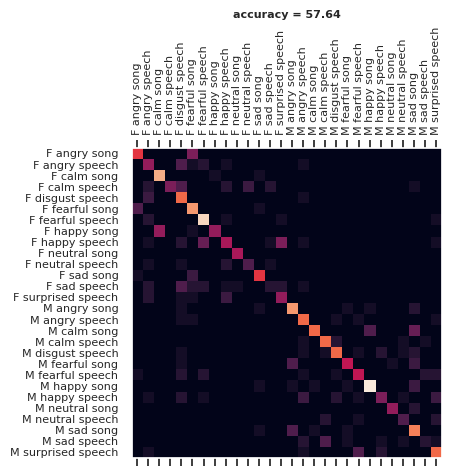

In [10]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.minorticks_off()
plt.grid(ls="")

## Tuning (for prediction of emotion only)

### Get labels

In [11]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = df.emotion.to_numpy()
y = enc.fit_transform(labels)

### Split dataset

In [12]:
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

### Belly network

In [13]:
X = STFT_dict[90]

belly_params = dict(conv_filter_sizes=[20, 15, 5 ], conv_kernel_sizes=[5,7, 4], conv_pool_sizes=[3,5, 7],
                    conv_padding="valid",
                   n_dense_layers=3, dense_nodes=256, 
                    batch_size=25, epochs=30,)
cnn = build_model(X.shape[1:], len(np.unique(y)), **belly_params)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=belly_params["epochs"], 
        batch_size=belly_params["batch_size"], validation_split=0.15)

Model: "sequential_301"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 333, 20)           9020      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 111, 20)          0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 105, 15)           2115      
                                                                 
 avg_pooling_1 (AveragePooli  (None, 21, 15)           0         
 ng1D)                                                           
                                                                 
 conv_2 (Conv1D)             (None, 18, 5)             305       
                                                                 
 flatten_301 (Flatten)       (None, 90)             

In [14]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 10ms/step
0.4847250509164969


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


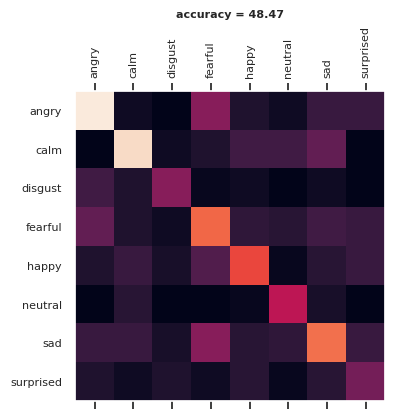

In [15]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.minorticks_off()
plt.grid(ls="")

### Start the study

In [16]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=300, n_jobs=1, catch=ValueError)

[I 2023-07-09 19:34:29,017] A new study created in memory with name: no-name-6ce91981-3736-4e5a-bf55-2333e675010a


running model having {'conv_filter_sizes': [7, 14], 'conv_kernel_sizes': [7, 9], 'conv_pool_sizes': [3, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 190} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:35:07,094] Trial 0 finished with value: 0.20816326530612245 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 3, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 190, 'batch_size': 26}. Best is trial 0 with value: 0.20816326530612245.


running model having {'conv_filter_sizes': [5], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76} with SpRes = 115 for epochs = 26


[I 2023-07-09 19:35:36,935] Trial 1 finished with value: 0.2979591836734694 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 5, 'kernels_0': 4, 'pool_0': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76, 'batch_size': 16}. Best is trial 1 with value: 0.2979591836734694.


running model having {'conv_filter_sizes': [8], 'conv_kernel_sizes': [9], 'conv_pool_sizes': [4], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 386} with SpRes = 115 for epochs = 25


[I 2023-07-09 19:36:31,634] Trial 2 finished with value: 0.20408163265306123 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 8, 'kernels_0': 9, 'pool_0': 4, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 386, 'batch_size': 30}. Best is trial 1 with value: 0.2979591836734694.


running model having {'conv_filter_sizes': [4, 9], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 445} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:37:00,061] Trial 3 finished with value: 0.3306122448979592 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 445, 'batch_size': 31}. Best is trial 3 with value: 0.3306122448979592.


running model having {'conv_filter_sizes': [16, 8], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [2, 7], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 25} with SpRes = 115 for epochs = 40


[I 2023-07-09 19:37:35,784] Trial 4 finished with value: 0.42448979591836733 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 8, 'kernels_1': 6, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 25, 'batch_size': 32}. Best is trial 4 with value: 0.42448979591836733.


running model having {'conv_filter_sizes': [2, 5, 12], 'conv_kernel_sizes': [8, 7, 9], 'conv_pool_sizes': [8, 3, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 317} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:38:15,226] Trial 5 finished with value: 0.4489795918367347 and parameters: {'epochs': 23, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 2, 'kernels_0': 8, 'pool_0': 8, 'filters_1': 5, 'kernels_1': 7, 'pool_1': 3, 'filters_2': 12, 'kernels_2': 9, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 317, 'batch_size': 18}. Best is trial 5 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [8, 2, 9], 'conv_kernel_sizes': [3, 7, 8], 'conv_pool_sizes': [2, 7, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 361} with SpRes = 115 for epochs = 26


[I 2023-07-09 19:38:44,165] Trial 6 finished with value: 0.45714285714285713 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 2, 'kernels_1': 7, 'pool_1': 7, 'filters_2': 9, 'kernels_2': 8, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 361, 'batch_size': 26}. Best is trial 6 with value: 0.45714285714285713.


running model having {'conv_filter_sizes': [9], 'conv_kernel_sizes': [8], 'conv_pool_sizes': [3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 60} with SpRes = 115 for epochs = 32


[I 2023-07-09 19:39:38,144] Trial 7 finished with value: 0.22448979591836735 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 60, 'batch_size': 31}. Best is trial 6 with value: 0.45714285714285713.


running model having {'conv_filter_sizes': [3, 10], 'conv_kernel_sizes': [9, 5], 'conv_pool_sizes': [7, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 403} with SpRes = 115 for epochs = 33


[I 2023-07-09 19:40:42,581] Trial 8 finished with value: 0.2693877551020408 and parameters: {'epochs': 33, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 3, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 5, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 403, 'batch_size': 17}. Best is trial 6 with value: 0.45714285714285713.


running model having {'conv_filter_sizes': [11, 15], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 231} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:41:13,845] Trial 9 finished with value: 0.5346938775510204 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 231, 'batch_size': 32}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [13, 16, 2], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 206} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:41:38,645] Trial 10 finished with value: 0.5346938775510204 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 2, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 206, 'batch_size': 21}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [13, 16, 2], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 222} with SpRes = 115 for epochs = 16


[I 2023-07-09 19:42:05,536] Trial 11 finished with value: 0.4122448979591837 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'filters_2': 2, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 222, 'batch_size': 21}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [12, 13, 2], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 142} with SpRes = 115 for epochs = 16


[I 2023-07-09 19:42:30,047] Trial 12 finished with value: 0.15510204081632653 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 2, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 142, 'batch_size': 22}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 278} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:42:58,102] Trial 13 finished with value: 0.3551020408163265 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 278, 'batch_size': 27}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [15, 12, 7], 'conv_kernel_sizes': [5, 3, 5], 'conv_pool_sizes': [8, 8, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 147} with SpRes = 115 for epochs = 19


[I 2023-07-09 19:43:24,684] Trial 14 finished with value: 0.4204081632653061 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 8, 'filters_2': 7, 'kernels_2': 5, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 147, 'batch_size': 21}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 262} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:43:53,541] Trial 15 finished with value: 0.34285714285714286 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 262, 'batch_size': 23}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [14, 12, 6], 'conv_kernel_sizes': [7, 4, 6], 'conv_pool_sizes': [7, 2, 8], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 145} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:44:26,976] Trial 16 finished with value: 0.3877551020408163 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 6, 'kernels_2': 6, 'pool_2': 8, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 145, 'batch_size': 28}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [10], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [7], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 220} with SpRes = 115 for epochs = 29


[I 2023-07-09 19:45:17,281] Trial 17 finished with value: 0.2 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 7, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 220, 'batch_size': 20}. Best is trial 9 with value: 0.5346938775510204.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 307} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:45:53,055] Trial 18 finished with value: 0.5551020408163265 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 307, 'batch_size': 24}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [8, 6], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 491} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:46:43,252] Trial 19 finished with value: 0.19183673469387755 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 6, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 491, 'batch_size': 25}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [10, 11], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [4, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 314} with SpRes = 115 for epochs = 29


[I 2023-07-09 19:47:19,058] Trial 20 finished with value: 0.34285714285714286 and parameters: {'epochs': 29, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 4, 'pool_0': 4, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 314, 'batch_size': 29}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 298} with SpRes = 115 for epochs = 17


[I 2023-07-09 19:47:49,566] Trial 21 finished with value: 0.49387755102040815 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 298, 'batch_size': 24}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [5, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 240} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:48:22,793] Trial 22 finished with value: 0.5020408163265306 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 240, 'batch_size': 19}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [12, 14, 16], 'conv_kernel_sizes': [7, 5, 3], 'conv_pool_sizes': [7, 6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 174} with SpRes = 115 for epochs = 21


[I 2023-07-09 19:48:59,394] Trial 23 finished with value: 0.4489795918367347 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 6, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 174, 'batch_size': 23}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 7], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [4, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 344} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:49:29,219] Trial 24 finished with value: 0.42448979591836733 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 4, 'filters_1': 7, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 344, 'batch_size': 24}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [11], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 101} with SpRes = 115 for epochs = 38


[I 2023-07-09 19:50:29,204] Trial 25 finished with value: 0.2612244897959184 and parameters: {'epochs': 38, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 101, 'batch_size': 22}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 12, 5], 'conv_kernel_sizes': [7, 3, 7], 'conv_pool_sizes': [5, 5, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 196} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:50:56,113] Trial 26 finished with value: 0.3795918367346939 and parameters: {'epochs': 15, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 5, 'filters_2': 5, 'kernels_2': 7, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 196, 'batch_size': 19}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [5, 7], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 261} with SpRes = 115 for epochs = 23


[I 2023-07-09 19:51:29,998] Trial 27 finished with value: 0.46122448979591835 and parameters: {'epochs': 23, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 261, 'batch_size': 28}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 347} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:52:08,024] Trial 28 finished with value: 0.4122448979591837 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 4, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 347, 'batch_size': 25}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [10], 'conv_kernel_sizes': [7], 'conv_pool_sizes': [7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 183} with SpRes = 115 for epochs = 17


[I 2023-07-09 19:52:39,605] Trial 29 finished with value: 0.22448979591836735 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 183, 'batch_size': 26}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [6, 13, 12], 'conv_kernel_sizes': [5, 4, 5], 'conv_pool_sizes': [8, 4, 8], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 113} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:53:10,513] Trial 30 finished with value: 0.46530612244897956 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 6, 'kernels_0': 5, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 12, 'kernels_2': 5, 'pool_2': 8, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 113, 'batch_size': 21}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [5, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 234} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:53:42,852] Trial 31 finished with value: 0.363265306122449 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 234, 'batch_size': 19}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [5, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 248} with SpRes = 115 for epochs = 15


[I 2023-07-09 19:54:11,387] Trial 32 finished with value: 0.42857142857142855 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 248, 'batch_size': 19}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [13, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [5, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 206} with SpRes = 115 for epochs = 18


[I 2023-07-09 19:54:48,351] Trial 33 finished with value: 0.4816326530612245 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 206, 'batch_size': 17}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [6, 6], 'conv_pool_sizes': [4, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 291} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:55:32,618] Trial 34 finished with value: 0.3673469387755102 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 4, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 291, 'batch_size': 20}. Best is trial 18 with value: 0.5551020408163265.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 410} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:55:59,092] Trial 35 finished with value: 0.5755102040816327 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 410, 'batch_size': 23}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [16], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [6], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 423} with SpRes = 115 for epochs = 25


[I 2023-07-09 19:57:01,389] Trial 36 finished with value: 0.19183673469387755 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 423, 'batch_size': 23}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 487} with SpRes = 115 for epochs = 22


[I 2023-07-09 19:57:29,773] Trial 37 finished with value: 0.5102040816326531 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 487, 'batch_size': 25}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [8, 14], 'conv_kernel_sizes': [4, 9], 'conv_pool_sizes': [3, 2], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 452} with SpRes = 115 for epochs = 27


[I 2023-07-09 19:58:10,051] Trial 38 finished with value: 0.35918367346938773 and parameters: {'epochs': 27, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 4, 'pool_0': 3, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 452, 'batch_size': 22}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [15], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [7], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 378} with SpRes = 115 for epochs = 24


[I 2023-07-09 19:58:58,202] Trial 39 finished with value: 0.22448979591836735 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 7, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 378, 'batch_size': 24}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [9, 11], 'conv_kernel_sizes': [8, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 323} with SpRes = 115 for epochs = 20


[I 2023-07-09 19:59:35,432] Trial 40 finished with value: 0.43673469387755104 and parameters: {'epochs': 20, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 323, 'batch_size': 32}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 485} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:00:00,315] Trial 41 finished with value: 0.563265306122449 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 485, 'batch_size': 30}. Best is trial 35 with value: 0.5755102040816327.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 466} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:00:24,742] Trial 42 finished with value: 0.5836734693877551 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 466, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 467} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:00:48,333] Trial 43 finished with value: 0.46938775510204084 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 467, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 419} with SpRes = 115 for epochs = 26


[I 2023-07-09 20:01:16,653] Trial 44 finished with value: 0.5469387755102041 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 419, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 3], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 420} with SpRes = 115 for epochs = 26


[I 2023-07-09 20:01:41,830] Trial 45 finished with value: 0.35918367346938773 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 3, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 420, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 6], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 396} with SpRes = 115 for epochs = 25


[I 2023-07-09 20:02:06,638] Trial 46 finished with value: 0.4326530612244898 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 6, 'kernels_1': 6, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 396, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [4, 16], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 509} with SpRes = 115 for epochs = 28


[I 2023-07-09 20:02:34,914] Trial 47 finished with value: 0.43673469387755104 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 509, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 433} with SpRes = 115 for epochs = 32


[I 2023-07-09 20:03:13,899] Trial 48 finished with value: 0.45714285714285713 and parameters: {'epochs': 32, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 433, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 9], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 463} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:03:38,714] Trial 49 finished with value: 0.42857142857142855 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 9, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 463, 'batch_size': 27}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [3, 9], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 479} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:04:04,651] Trial 50 finished with value: 0.5020408163265306 and parameters: {'epochs': 21, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 13, 'kernels_1': 9, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 479, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 506} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:04:29,142] Trial 51 finished with value: 0.5020408163265306 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 506, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 407} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:04:51,414] Trial 52 finished with value: 0.49387755102040815 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 407, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [2, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 376} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:05:23,787] Trial 53 finished with value: 0.2938775510204082 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 376, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 437} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:05:49,845] Trial 54 finished with value: 0.5469387755102041 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 437, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [7, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 443} with SpRes = 115 for epochs = 24


[I 2023-07-09 20:06:18,307] Trial 55 finished with value: 0.46530612244897956 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 443, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [5, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 411} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:06:47,157] Trial 56 finished with value: 0.4448979591836735 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 411, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 444} with SpRes = 115 for epochs = 30


[I 2023-07-09 20:07:23,446] Trial 57 finished with value: 0.3836734693877551 and parameters: {'epochs': 30, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 444, 'batch_size': 27}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 462} with SpRes = 115 for epochs = 36


[I 2023-07-09 20:08:02,908] Trial 58 finished with value: 0.5224489795918368 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 462, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 363} with SpRes = 115 for epochs = 26


[I 2023-07-09 20:08:54,159] Trial 59 finished with value: 0.46530612244897956 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 363, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [5, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 392} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:09:13,895] Trial 60 finished with value: 0.4775510204081633 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 7, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 392, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 15], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [6, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 478} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:09:47,081] Trial 61 finished with value: 0.4897959183673469 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 478, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 430} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:10:14,774] Trial 62 finished with value: 0.5428571428571428 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 430, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 437} with SpRes = 115 for epochs = 17


[I 2023-07-09 20:10:38,980] Trial 63 finished with value: 0.4897959183673469 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 437, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 497} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:11:08,086] Trial 64 finished with value: 0.3877551020408163 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 497, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [5, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 426} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:11:39,030] Trial 65 finished with value: 0.5469387755102041 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 426, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [5, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 333} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:12:10,560] Trial 66 finished with value: 0.4163265306122449 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 333, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [5, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 454} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:12:42,880] Trial 67 finished with value: 0.46530612244897956 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 454, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [2, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 413} with SpRes = 115 for epochs = 25


[I 2023-07-09 20:13:18,257] Trial 68 finished with value: 0.19183673469387755 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 2, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 413, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 13], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [4, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 381} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:13:41,004] Trial 69 finished with value: 0.5102040816326531 and parameters: {'epochs': 19, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 381, 'batch_size': 26}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:14:05,307] Trial 70 finished with value: 0.5102040816326531 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 16} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:14:25,765] Trial 71 finished with value: 0.3877551020408163 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 16, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 430} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:14:53,813] Trial 72 finished with value: 0.4897959183673469 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 430, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [5, 5], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 363} with SpRes = 115 for epochs = 16


[I 2023-07-09 20:15:17,898] Trial 73 finished with value: 0.49795918367346936 and parameters: {'epochs': 16, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 363, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 8], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 400} with SpRes = 115 for epochs = 18


[I 2023-07-09 20:15:41,476] Trial 74 finished with value: 0.5142857142857142 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 8, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 400, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 487} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:16:13,463] Trial 75 finished with value: 0.5183673469387755 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 487, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [5, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 453} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:16:39,564] Trial 76 finished with value: 0.4897959183673469 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 453, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 8], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 428} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:17:06,490] Trial 77 finished with value: 0.40408163265306124 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 428, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15], 'conv_kernel_sizes': [3], 'conv_pool_sizes': [6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 498} with SpRes = 115 for epochs = 24


[I 2023-07-09 20:17:55,542] Trial 78 finished with value: 0.3020408163265306 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 498, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16, 16], 'conv_kernel_sizes': [4, 5, 9], 'conv_pool_sizes': [7, 7, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 421} with SpRes = 115 for epochs = 27


[I 2023-07-09 20:18:28,602] Trial 79 finished with value: 0.5020408163265306 and parameters: {'epochs': 27, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 7, 'filters_2': 16, 'kernels_2': 9, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 421, 'batch_size': 27}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 11], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 300} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:18:52,621] Trial 80 finished with value: 0.42857142857142855 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 300, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [10, 15], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 257} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:19:23,692] Trial 81 finished with value: 0.5183673469387755 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 257, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 273} with SpRes = 115 for epochs = 17


[I 2023-07-09 20:19:52,260] Trial 82 finished with value: 0.46122448979591835 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 273, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 4], 'conv_kernel_sizes': [5, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 167} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:20:16,599] Trial 83 finished with value: 0.4326530612244898 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 4, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 167, 'batch_size': 26}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 235} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:20:51,692] Trial 84 finished with value: 0.46530612244897956 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 235, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476} with SpRes = 115 for epochs = 18


[I 2023-07-09 20:21:21,582] Trial 85 finished with value: 0.42448979591836733 and parameters: {'epochs': 18, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [7, 14], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 221} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:21:56,319] Trial 86 finished with value: 0.4204081632653061 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 221, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [9, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [7, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 351} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:22:18,254] Trial 87 finished with value: 0.40816326530612246 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 351, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [5, 6], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 447} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:22:59,474] Trial 88 finished with value: 0.46938775510204084 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 6, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 447, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 389} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:23:23,501] Trial 89 finished with value: 0.49795918367346936 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 389, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 413} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:23:46,248] Trial 90 finished with value: 0.5061224489795918 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 413, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 16, 4], 'conv_kernel_sizes': [6, 3, 5], 'conv_pool_sizes': [7, 2, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 192} with SpRes = 115 for epochs = 15


[I 2023-07-09 20:24:11,141] Trial 91 finished with value: 0.5224489795918368 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 4, 'kernels_2': 5, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 192, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15, 9], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 199} with SpRes = 115 for epochs = 17


[I 2023-07-09 20:24:40,665] Trial 92 finished with value: 0.5061224489795918 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 9, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 199, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16, 13], 'conv_kernel_sizes': [6, 3, 7], 'conv_pool_sizes': [6, 3, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 210} with SpRes = 115 for epochs = 16


[I 2023-07-09 20:25:06,348] Trial 93 finished with value: 0.5142857142857142 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 7, 'pool_2': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 210, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 155} with SpRes = 115 for epochs = 18


[I 2023-07-09 20:25:38,687] Trial 94 finished with value: 0.35918367346938773 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 155, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [6, 4], 'conv_pool_sizes': [5, 2], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 49} with SpRes = 115 for epochs = 30


[I 2023-07-09 20:26:23,747] Trial 95 finished with value: 0.4530612244897959 and parameters: {'epochs': 30, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 49, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 465} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:26:58,938] Trial 96 finished with value: 0.5387755102040817 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 465, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 460} with SpRes = 115 for epochs = 24


[I 2023-07-09 20:27:35,232] Trial 97 finished with value: 0.5020408163265306 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 460, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 438} with SpRes = 115 for epochs = 22


[I 2023-07-09 20:28:03,944] Trial 98 finished with value: 0.5061224489795918 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 4, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 438, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 510} with SpRes = 115 for epochs = 19


[I 2023-07-09 20:28:28,632] Trial 99 finished with value: 0.3877551020408163 and parameters: {'epochs': 19, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 510, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [5, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 480} with SpRes = 115 for epochs = 20


[I 2023-07-09 20:28:54,176] Trial 100 finished with value: 0.5102040816326531 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 480, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 401} with SpRes = 115 for epochs = 23


[I 2023-07-09 20:29:36,054] Trial 101 finished with value: 0.4204081632653061 and parameters: {'epochs': 23, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 401, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 130} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:30:22,796] Trial 102 finished with value: 0.5551020408163265 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 130, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 109} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:31:05,608] Trial 103 finished with value: 0.5428571428571428 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 109, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 108} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:31:51,733] Trial 104 finished with value: 0.44081632653061226 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 108, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 83} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:32:33,183] Trial 105 finished with value: 0.5306122448979592 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 83, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 93} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:33:12,473] Trial 106 finished with value: 0.45714285714285713 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 93, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 60} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:33:55,470] Trial 107 finished with value: 0.4163265306122449 and parameters: {'epochs': 39, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 60, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 10], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121} with SpRes = 115 for epochs = 35


[I 2023-07-09 20:34:32,540] Trial 108 finished with value: 0.46530612244897956 and parameters: {'epochs': 35, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 5, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 467} with SpRes = 115 for epochs = 34


[I 2023-07-09 20:35:08,949] Trial 109 finished with value: 0.5061224489795918 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 467, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 123} with SpRes = 115 for epochs = 21


[I 2023-07-09 20:35:37,949] Trial 110 finished with value: 0.5224489795918368 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 123, 'batch_size': 16}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [4, 4], 'conv_pool_sizes': [6, 7], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 424} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:36:39,423] Trial 111 finished with value: 0.4 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 7, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 424, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 128} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:37:17,661] Trial 112 finished with value: 0.5510204081632653 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 128, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 135} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:37:56,354] Trial 113 finished with value: 0.5673469387755102 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 135, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 117} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:38:34,534] Trial 114 finished with value: 0.5061224489795918 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 117, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 136} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:39:13,035] Trial 115 finished with value: 0.49387755102040815 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 136, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [5, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 143} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:39:51,484] Trial 116 finished with value: 0.46530612244897956 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 143, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:40:26,008] Trial 117 finished with value: 0.5510204081632653 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 44} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:40:59,789] Trial 118 finished with value: 0.5428571428571428 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 44, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 127} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:41:35,878] Trial 119 finished with value: 0.5183673469387755 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 127, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 158} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:42:10,507] Trial 120 finished with value: 0.5591836734693878 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 158, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 157} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:42:46,600] Trial 121 finished with value: 0.46530612244897956 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 157, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 179} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:43:21,604] Trial 122 finished with value: 0.5428571428571428 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 179, 'batch_size': 30}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:43:58,346] Trial 123 finished with value: 0.5551020408163265 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:44:33,774] Trial 124 finished with value: 0.47346938775510206 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 72} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:45:09,918] Trial 125 finished with value: 0.4530612244897959 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 72, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 99} with SpRes = 115 for epochs = 36


[I 2023-07-09 20:45:41,973] Trial 126 finished with value: 0.5387755102040817 and parameters: {'epochs': 36, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 99, 'batch_size': 28}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [5, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 68} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:46:18,571] Trial 127 finished with value: 0.5265306122448979 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 68, 'batch_size': 27}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 7], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 148} with SpRes = 115 for epochs = 36


[I 2023-07-09 20:46:52,775] Trial 128 finished with value: 0.5346938775510204 and parameters: {'epochs': 36, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 7, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 148, 'batch_size': 29}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 131} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:47:28,784] Trial 129 finished with value: 0.5510204081632653 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 131, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:48:03,724] Trial 130 finished with value: 0.563265306122449 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:48:38,947] Trial 131 finished with value: 0.4897959183673469 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 133} with SpRes = 115 for epochs = 35


[I 2023-07-09 20:49:13,076] Trial 132 finished with value: 0.46122448979591835 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 133, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 81} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:49:49,051] Trial 133 finished with value: 0.4489795918367347 and parameters: {'epochs': 38, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 81, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 162} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:51:01,632] Trial 134 finished with value: 0.2816326530612245 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 162, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 13], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:51:38,521] Trial 135 finished with value: 0.4857142857142857 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 115} with SpRes = 115 for epochs = 36


[I 2023-07-09 20:52:13,677] Trial 136 finished with value: 0.4122448979591837 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 115, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 2], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 134} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:52:50,168] Trial 137 finished with value: 0.43673469387755104 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 2, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 134, 'batch_size': 26}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 173} with SpRes = 115 for epochs = 35


[I 2023-07-09 20:53:49,934] Trial 138 finished with value: 0.5346938775510204 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 173, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110} with SpRes = 115 for epochs = 32


[I 2023-07-09 20:54:22,023] Trial 139 finished with value: 0.563265306122449 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110} with SpRes = 115 for epochs = 32


[I 2023-07-09 20:54:54,455] Trial 140 finished with value: 0.5224489795918368 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 131} with SpRes = 115 for epochs = 28


[I 2023-07-09 20:55:24,569] Trial 141 finished with value: 0.49795918367346936 and parameters: {'epochs': 28, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 131, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 145} with SpRes = 115 for epochs = 33


[I 2023-07-09 20:55:57,110] Trial 142 finished with value: 0.42448979591836733 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 145, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 105} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:56:36,863] Trial 143 finished with value: 0.563265306122449 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 105, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [3, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:57:17,428] Trial 144 finished with value: 0.5673469387755102 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 3, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [3, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 65} with SpRes = 115 for epochs = 39


[I 2023-07-09 20:57:57,225] Trial 145 finished with value: 0.5020408163265306 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 3, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 65, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [2, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98} with SpRes = 115 for epochs = 38


[I 2023-07-09 20:58:40,307] Trial 146 finished with value: 0.42448979591836733 and parameters: {'epochs': 38, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [3, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 78} with SpRes = 115 for epochs = 40


[I 2023-07-09 20:59:20,507] Trial 147 finished with value: 0.40816326530612246 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 3, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 78, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [3, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 103} with SpRes = 115 for epochs = 37


[I 2023-07-09 20:59:57,319] Trial 148 finished with value: 0.4489795918367347 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 3, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 103, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [4, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 52} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:00:31,838] Trial 149 finished with value: 0.40816326530612246 and parameters: {'epochs': 38, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 52, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 119} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:01:10,533] Trial 150 finished with value: 0.5020408163265306 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 119, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 126} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:01:51,141] Trial 151 finished with value: 0.5428571428571428 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 126, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [2, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 83} with SpRes = 115 for epochs = 40


[I 2023-07-09 21:02:36,261] Trial 152 finished with value: 0.49387755102040815 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 83, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 109} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:03:13,395] Trial 153 finished with value: 0.5714285714285714 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 109, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:03:52,720] Trial 154 finished with value: 0.5755102040816327 and parameters: {'epochs': 38, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 111} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:04:30,842] Trial 155 finished with value: 0.5591836734693878 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 111, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [6, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:05:07,928] Trial 156 finished with value: 0.49795918367346936 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 6, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 117} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:05:47,351] Trial 157 finished with value: 0.5714285714285714 and parameters: {'epochs': 39, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 117, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:06:26,896] Trial 158 finished with value: 0.5265306122448979 and parameters: {'epochs': 39, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 107} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:07:04,633] Trial 159 finished with value: 0.5591836734693878 and parameters: {'epochs': 36, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 107, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 143} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:07:42,609] Trial 160 finished with value: 0.5020408163265306 and parameters: {'epochs': 36, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 143, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 101} with SpRes = 115 for epochs = 30


[I 2023-07-09 21:08:13,058] Trial 161 finished with value: 0.5102040816326531 and parameters: {'epochs': 30, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 101, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 91} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:08:50,610] Trial 162 finished with value: 0.5224489795918368 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 91, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:09:26,883] Trial 163 finished with value: 0.5265306122448979 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:10:06,316] Trial 164 finished with value: 0.5183673469387755 and parameters: {'epochs': 39, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 95} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:10:44,156] Trial 165 finished with value: 0.5469387755102041 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 95, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 72} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:11:21,070] Trial 166 finished with value: 0.5142857142857142 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 72, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:12:01,462] Trial 167 finished with value: 0.5306122448979592 and parameters: {'epochs': 39, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 150} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:12:38,734] Trial 168 finished with value: 0.5061224489795918 and parameters: {'epochs': 36, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 150, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 103} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:13:16,521] Trial 169 finished with value: 0.5224489795918368 and parameters: {'epochs': 38, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 103, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 495} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:13:54,882] Trial 170 finished with value: 0.5714285714285714 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 495, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 498} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:14:39,831] Trial 171 finished with value: 0.5183673469387755 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 498, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 82} with SpRes = 115 for epochs = 29


[I 2023-07-09 21:15:08,836] Trial 172 finished with value: 0.5795918367346938 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 82, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 484} with SpRes = 115 for epochs = 32


[I 2023-07-09 21:15:50,297] Trial 173 finished with value: 0.4897959183673469 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 484, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 80} with SpRes = 115 for epochs = 29


[I 2023-07-09 21:16:19,371] Trial 174 finished with value: 0.46530612244897956 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 80, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 314} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:16:55,655] Trial 175 finished with value: 0.563265306122449 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 314, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 283} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:17:30,356] Trial 176 finished with value: 0.5142857142857142 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 283, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 311} with SpRes = 115 for epochs = 30


[I 2023-07-09 21:18:05,276] Trial 177 finished with value: 0.5346938775510204 and parameters: {'epochs': 30, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 311, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 502} with SpRes = 115 for epochs = 29


[I 2023-07-09 21:18:40,306] Trial 178 finished with value: 0.5102040816326531 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 502, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 333} with SpRes = 115 for epochs = 27


[I 2023-07-09 21:19:11,723] Trial 179 finished with value: 0.5428571428571428 and parameters: {'epochs': 27, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 333, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 493} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:19:50,223] Trial 180 finished with value: 0.5836734693877551 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 493, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 491} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:20:27,398] Trial 181 finished with value: 0.4489795918367347 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 491, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 491} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:21:05,294] Trial 182 finished with value: 0.5020408163265306 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 491, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 481} with SpRes = 115 for epochs = 32


[I 2023-07-09 21:21:44,381] Trial 183 finished with value: 0.5102040816326531 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 481, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 510} with SpRes = 115 for epochs = 33


[I 2023-07-09 21:22:26,637] Trial 184 finished with value: 0.5306122448979592 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 510, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 248} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:23:04,810] Trial 185 finished with value: 0.47346938775510206 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 248, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 271} with SpRes = 115 for epochs = 30


[I 2023-07-09 21:23:39,804] Trial 186 finished with value: 0.5387755102040817 and parameters: {'epochs': 30, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 271, 'batch_size': 19}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 368} with SpRes = 115 for epochs = 33


[I 2023-07-09 21:24:42,697] Trial 187 finished with value: 0.5102040816326531 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 368, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 473} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:25:21,110] Trial 188 finished with value: 0.363265306122449 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 473, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 119} with SpRes = 115 for epochs = 34


[I 2023-07-09 21:25:55,722] Trial 189 finished with value: 0.47346938775510206 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 119, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 292} with SpRes = 115 for epochs = 30


[I 2023-07-09 21:26:38,628] Trial 190 finished with value: 0.5183673469387755 and parameters: {'epochs': 30, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 292, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 89} with SpRes = 115 for epochs = 40


[I 2023-07-09 21:27:17,519] Trial 191 finished with value: 0.5306122448979592 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 89, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 107} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:27:57,076] Trial 192 finished with value: 0.4857142857142857 and parameters: {'epochs': 39, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 107, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124} with SpRes = 115 for epochs = 32


[I 2023-07-09 21:28:29,455] Trial 193 finished with value: 0.5224489795918368 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 139} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:29:09,049] Trial 194 finished with value: 0.43673469387755104 and parameters: {'epochs': 39, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 8, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 139, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 353} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:29:50,424] Trial 195 finished with value: 0.5183673469387755 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 353, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 90} with SpRes = 115 for epochs = 29


[I 2023-07-09 21:30:18,408] Trial 196 finished with value: 0.4775510204081633 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 90, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 40


[I 2023-07-09 21:30:58,595] Trial 197 finished with value: 0.5183673469387755 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 60} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:31:33,841] Trial 198 finished with value: 0.4204081632653061 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 60, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 9], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 305} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:32:08,008] Trial 199 finished with value: 0.4775510204081633 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 305, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:32:48,285] Trial 200 finished with value: 0.5265306122448979 and parameters: {'epochs': 39, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 100} with SpRes = 115 for epochs = 28


[I 2023-07-09 21:33:19,079] Trial 201 finished with value: 0.5551020408163265 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 100, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 325} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:34:02,546] Trial 202 finished with value: 0.5061224489795918 and parameters: {'epochs': 37, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 325, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 10], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:34:41,467] Trial 203 finished with value: 0.46938775510204084 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 5], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 102} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:35:17,720] Trial 204 finished with value: 0.3469387755102041 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 102, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 128} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:35:57,778] Trial 205 finished with value: 0.5714285714285714 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 128, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 133} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:36:43,235] Trial 206 finished with value: 0.5183673469387755 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 133, 'batch_size': 17}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [8, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124} with SpRes = 115 for epochs = 35


[I 2023-07-09 21:37:18,601] Trial 207 finished with value: 0.5142857142857142 and parameters: {'epochs': 35, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 113} with SpRes = 115 for epochs = 25


[I 2023-07-09 21:37:48,538] Trial 208 finished with value: 0.46530612244897956 and parameters: {'epochs': 25, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 113, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 137} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:38:37,341] Trial 209 finished with value: 0.5306122448979592 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 137, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 502} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:39:26,966] Trial 210 finished with value: 0.5224489795918368 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 502, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:40:10,077] Trial 211 finished with value: 0.4897959183673469 and parameters: {'epochs': 37, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 110, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 84} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:40:51,373] Trial 212 finished with value: 0.49387755102040815 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 84, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:41:32,037] Trial 213 finished with value: 0.5142857142857142 and parameters: {'epochs': 36, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 121, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:42:14,071] Trial 214 finished with value: 0.5102040816326531 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 487} with SpRes = 115 for epochs = 40


[I 2023-07-09 21:43:08,520] Trial 215 finished with value: 0.5142857142857142 and parameters: {'epochs': 40, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 487, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 96} with SpRes = 115 for epochs = 34


[I 2023-07-09 21:43:46,161] Trial 216 finished with value: 0.563265306122449 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 96, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 32} with SpRes = 115 for epochs = 35


[I 2023-07-09 21:44:22,626] Trial 217 finished with value: 0.5020408163265306 and parameters: {'epochs': 35, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 32, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 129} with SpRes = 115 for epochs = 34


[I 2023-07-09 21:44:57,992] Trial 218 finished with value: 0.4204081632653061 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 129, 'batch_size': 26}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 156} with SpRes = 115 for epochs = 33


[I 2023-07-09 21:45:33,951] Trial 219 finished with value: 0.5387755102040817 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 156, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 94} with SpRes = 115 for epochs = 32


[I 2023-07-09 21:46:08,321] Trial 220 finished with value: 0.5306122448979592 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 94, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 100} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:46:50,258] Trial 221 finished with value: 0.5102040816326531 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 100, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:47:25,659] Trial 222 finished with value: 0.5428571428571428 and parameters: {'epochs': 31, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 82} with SpRes = 115 for epochs = 34


[I 2023-07-09 21:48:03,731] Trial 223 finished with value: 0.5306122448979592 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 82, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 118} with SpRes = 115 for epochs = 36


[I 2023-07-09 21:48:45,021] Trial 224 finished with value: 0.5306122448979592 and parameters: {'epochs': 36, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 118, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:49:24,542] Trial 225 finished with value: 0.49387755102040815 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93, 'batch_size': 26}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 8], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 109} with SpRes = 115 for epochs = 30


[I 2023-07-09 21:49:58,457] Trial 226 finished with value: 0.4204081632653061 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 109, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [2, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 71} with SpRes = 115 for epochs = 35


[I 2023-07-09 21:50:43,971] Trial 227 finished with value: 0.3836734693877551 and parameters: {'epochs': 35, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 2, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 71, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 127} with SpRes = 115 for epochs = 37


[I 2023-07-09 21:51:23,158] Trial 228 finished with value: 0.5551020408163265 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 127, 'batch_size': 27}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [3, 2], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 495} with SpRes = 115 for epochs = 19


[I 2023-07-09 21:52:01,234] Trial 229 finished with value: 0.5142857142857142 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 3, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 495, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476} with SpRes = 115 for epochs = 38


[I 2023-07-09 21:53:36,270] Trial 230 finished with value: 0.23673469387755103 and parameters: {'epochs': 38, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 101} with SpRes = 115 for epochs = 28


[I 2023-07-09 21:54:07,667] Trial 231 finished with value: 0.42448979591836733 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 101, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [4, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98} with SpRes = 115 for epochs = 28


[I 2023-07-09 21:54:41,119] Trial 232 finished with value: 0.49795918367346936 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 98, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88} with SpRes = 115 for epochs = 27


[I 2023-07-09 21:55:12,518] Trial 233 finished with value: 0.5142857142857142 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 88, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 116} with SpRes = 115 for epochs = 26


[I 2023-07-09 21:55:44,883] Trial 234 finished with value: 0.5142857142857142 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 116, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104} with SpRes = 115 for epochs = 31


[I 2023-07-09 21:56:20,386] Trial 235 finished with value: 0.4530612244897959 and parameters: {'epochs': 31, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 77} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:57:03,904] Trial 236 finished with value: 0.5714285714285714 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 77, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 14], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:57:46,220] Trial 237 finished with value: 0.4897959183673469 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 76, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [9, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 59} with SpRes = 115 for epochs = 40


[I 2023-07-09 21:58:29,436] Trial 238 finished with value: 0.43673469387755104 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 59, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 85} with SpRes = 115 for epochs = 39


[I 2023-07-09 21:59:12,376] Trial 239 finished with value: 0.5346938775510204 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 85, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 341} with SpRes = 115 for epochs = 38


[I 2023-07-09 22:00:03,533] Trial 240 finished with value: 0.4775510204081633 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 341, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:00:38,265] Trial 241 finished with value: 0.5755102040816327 and parameters: {'epochs': 29, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 93, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 71} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:01:11,672] Trial 242 finished with value: 0.4775510204081633 and parameters: {'epochs': 29, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 71, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 94} with SpRes = 115 for epochs = 20


[I 2023-07-09 22:01:35,683] Trial 243 finished with value: 0.5265306122448979 and parameters: {'epochs': 20, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 94, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 39


[I 2023-07-09 22:02:18,561] Trial 244 finished with value: 0.5510204081632653 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 79} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:02:51,926] Trial 245 finished with value: 0.4326530612244898 and parameters: {'epochs': 32, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 79, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 14], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 143} with SpRes = 115 for epochs = 37


[I 2023-07-09 22:03:27,113] Trial 246 finished with value: 0.49387755102040815 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 143, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 121} with SpRes = 115 for epochs = 38


[I 2023-07-09 22:04:06,534] Trial 247 finished with value: 0.5224489795918368 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 121, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:04:35,867] Trial 248 finished with value: 0.5510204081632653 and parameters: {'epochs': 30, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 458} with SpRes = 115 for epochs = 39


[I 2023-07-09 22:05:23,995] Trial 249 finished with value: 0.47346938775510206 and parameters: {'epochs': 39, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 458, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 16], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108} with SpRes = 115 for epochs = 40


[I 2023-07-09 22:06:01,154] Trial 250 finished with value: 0.5306122448979592 and parameters: {'epochs': 40, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 108, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [13, 15], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 96} with SpRes = 115 for epochs = 38


[I 2023-07-09 22:06:54,483] Trial 251 finished with value: 0.49795918367346936 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 96, 'batch_size': 21}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 488} with SpRes = 115 for epochs = 36


[I 2023-07-09 22:07:40,446] Trial 252 finished with value: 0.42857142857142855 and parameters: {'epochs': 36, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 488, 'batch_size': 20}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 134} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:08:10,552] Trial 253 finished with value: 0.49387755102040815 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 134, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 113} with SpRes = 115 for epochs = 37


[I 2023-07-09 22:08:46,693] Trial 254 finished with value: 0.5591836734693878 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 113, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 511} with SpRes = 115 for epochs = 39


[I 2023-07-09 22:09:31,400] Trial 255 finished with value: 0.5469387755102041 and parameters: {'epochs': 39, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 511, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 118} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:10:02,723] Trial 256 finished with value: 0.5673469387755102 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 118, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 113} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:10:33,809] Trial 257 finished with value: 0.5673469387755102 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 113, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 116} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:11:03,968] Trial 258 finished with value: 0.563265306122449 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 116, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 122} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:11:34,231] Trial 259 finished with value: 0.5183673469387755 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 122, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 105} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:12:05,111] Trial 260 finished with value: 0.5469387755102041 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 105, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16], 'conv_kernel_sizes': [3], 'conv_pool_sizes': [6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:12:43,899] Trial 261 finished with value: 0.37142857142857144 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:13:14,233] Trial 262 finished with value: 0.49795918367346936 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 90} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:13:45,709] Trial 263 finished with value: 0.5224489795918368 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 90, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:14:16,184] Trial 264 finished with value: 0.5755102040816327 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 104, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:14:46,822] Trial 265 finished with value: 0.5061224489795918 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 99, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 469} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:15:25,545] Trial 266 finished with value: 0.4857142857142857 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 469, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 498} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:16:00,141] Trial 267 finished with value: 0.4857142857142857 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 498, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 135} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:16:32,724] Trial 268 finished with value: 0.46122448979591835 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 135, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 10], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 115} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:17:04,680] Trial 269 finished with value: 0.4489795918367347 and parameters: {'epochs': 33, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 115, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:17:33,800] Trial 270 finished with value: 0.5102040816326531 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 86, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:18:03,771] Trial 271 finished with value: 0.5387755102040817 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 124, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 106} with SpRes = 115 for epochs = 34


[I 2023-07-09 22:18:34,218] Trial 272 finished with value: 0.5551020408163265 and parameters: {'epochs': 34, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 106, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 64} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:19:02,348] Trial 273 finished with value: 0.5714285714285714 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 64, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 48} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:19:31,227] Trial 274 finished with value: 0.44081632653061226 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 48, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 58} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:19:59,143] Trial 275 finished with value: 0.5102040816326531 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 58, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 35} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:20:26,030] Trial 276 finished with value: 0.5755102040816327 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 35, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 66} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:20:52,252] Trial 277 finished with value: 0.5306122448979592 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 66, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 37} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:21:18,819] Trial 278 finished with value: 0.5020408163265306 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 37, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 12], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 16} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:21:46,314] Trial 279 finished with value: 0.49795918367346936 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 16, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 42} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:22:14,467] Trial 280 finished with value: 0.5551020408163265 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 42, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [10, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 74} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:22:43,812] Trial 281 finished with value: 0.49387755102040815 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 74, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 80} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:23:12,947] Trial 282 finished with value: 0.5224489795918368 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 80, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 56} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:23:42,262] Trial 283 finished with value: 0.40816326530612246 and parameters: {'epochs': 32, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 56, 'batch_size': 32}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 211} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:24:13,777] Trial 284 finished with value: 0.5183673469387755 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 211, 'batch_size': 24}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 13], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 70} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:24:39,869] Trial 285 finished with value: 0.5020408163265306 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 70, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 14], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 33} with SpRes = 115 for epochs = 33


[I 2023-07-09 22:25:12,379] Trial 286 finished with value: 0.5183673469387755 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 33, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [16, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 92} with SpRes = 115 for epochs = 32


[I 2023-07-09 22:25:41,352] Trial 287 finished with value: 0.5387755102040817 and parameters: {'epochs': 32, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 92, 'batch_size': 23}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 478} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:26:16,633] Trial 288 finished with value: 0.5673469387755102 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 478, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [7, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 490} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:26:53,188] Trial 289 finished with value: 0.47346938775510206 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 490, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 485} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:27:34,844] Trial 290 finished with value: 0.46530612244897956 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 485, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 477} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:28:09,648] Trial 291 finished with value: 0.47346938775510206 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 477, 'batch_size': 25}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [15, 15], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 448} with SpRes = 115 for epochs = 31


[I 2023-07-09 22:28:45,222] Trial 292 finished with value: 0.5020408163265306 and parameters: {'epochs': 31, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 448, 'batch_size': 22}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:29:25,015] Trial 293 finished with value: 0.5714285714285714 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471, 'batch_size': 16}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 483} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:30:01,920] Trial 294 finished with value: 0.42857142857142855 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 483, 'batch_size': 19}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 463} with SpRes = 115 for epochs = 30


[I 2023-07-09 22:30:34,354] Trial 295 finished with value: 0.5551020408163265 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 463, 'batch_size': 31}. Best is trial 42 with value: 0.5836734693877551.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 477} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:31:05,123] Trial 296 finished with value: 0.5877551020408164 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 477, 'batch_size': 32}. Best is trial 296 with value: 0.5877551020408164.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:31:42,624] Trial 297 finished with value: 0.49795918367346936 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476, 'batch_size': 17}. Best is trial 296 with value: 0.5877551020408164.


running model having {'conv_filter_sizes': [10, 14], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 501} with SpRes = 115 for epochs = 29


[I 2023-07-09 22:32:13,214] Trial 298 finished with value: 0.5551020408163265 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 6, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 501, 'batch_size': 32}. Best is trial 296 with value: 0.5877551020408164.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [7, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471} with SpRes = 115 for epochs = 28


[I 2023-07-09 22:32:42,709] Trial 299 finished with value: 0.5183673469387755 and parameters: {'epochs': 28, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 471, 'batch_size': 32}. Best is trial 296 with value: 0.5877551020408164.


## Results

In [17]:
best_params_emotion = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_emotion["conv_filter_sizes"] = []
best_params_emotion["conv_kernel_sizes"] = []
best_params_emotion["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_emotion["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_emotion["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_emotion["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_emotion)
        
        
        
X = STFT_dict[best_params_emotion["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_emotion)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_emotion["epochs"], 
        batch_size=best_params_emotion["batch_size"])

for all-class best is {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 477, 'batch_size': 32, 'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [7, 5]}
Model: "sequential_602"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 276, 11)           3641      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 39, 11)           0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 39, 14)            1246      
                                                                 
 flatten_602 (Flatten)       (None, 546)  

In [18]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 8ms/step
0.439918533604888


              precision    recall  f1-score   support

       angry       0.49      0.40      0.44        85
        calm       0.61      0.52      0.56        79
     disgust       0.39      0.33      0.36        33
     fearful       0.34      0.46      0.39        76
       happy       0.47      0.47      0.47        66
     neutral       0.35      0.45      0.39        31
         sad       0.48      0.44      0.46        84
   surprised       0.32      0.35      0.33        37

    accuracy                           0.44       491
   macro avg       0.43      0.43      0.43       491
weighted avg       0.45      0.44      0.44       491



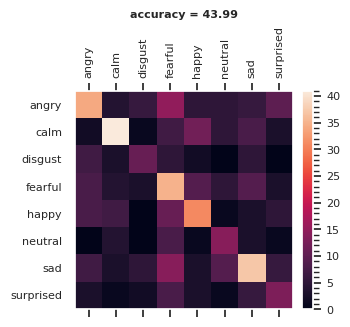

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

fig, ax = plt.subplots(1,1,figsize=default_style.HALFSIZE_FIGURE)

im = ax.matshow(confusion_matrix(y[test_idxs], ypred))
ax.set_xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
ax.set_yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

ax.set_title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
ax.grid(ls="")
ax.minorticks_off()
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig("../images/ts_emotion_classification.pdf")
print(classification_report(enc.inverse_transform(y[test_idxs]), enc.inverse_transform(ypred)))

## Print filters

In [20]:
for layer in cnn.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)


conv_0 (3, 110, 11)
conv_1 (8, 11, 14)


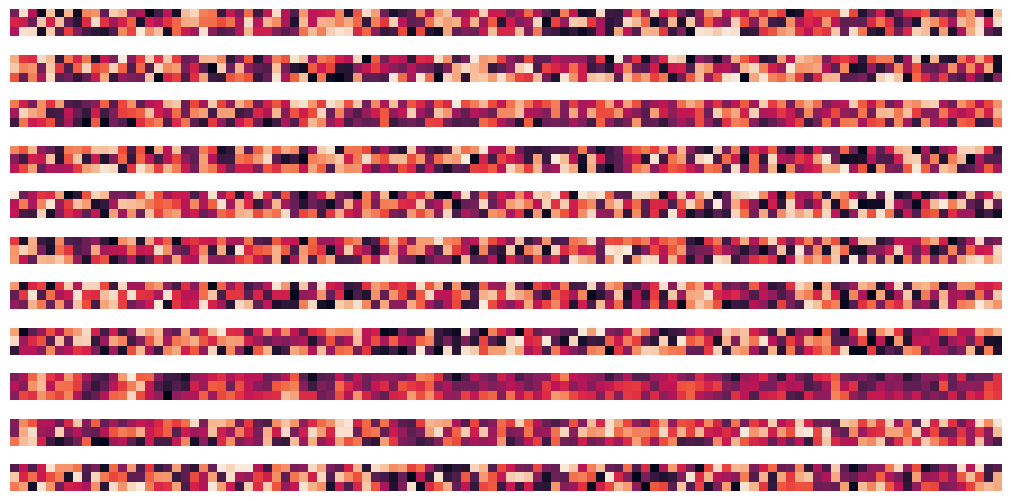

In [21]:
filters, biases = cnn.get_layer("conv_0").get_weights()

n_filters = filters.shape[-1]
fig, axes = plt.subplots(n_filters, 1, 
                         sharex=True, 
                         figsize=(10, 5), 
                         constrained_layout=True)
for i in range(n_filters):
    axes[i].axis("off")
    axes[i].matshow(filters[:,:,i])
